In [ ]:
#!/usr/bin/python

# Filename: git_U_run_analysis_of_ens_members_ua_ssp585_regout_comm
#
# Code by Hilla Gerstman
#
# This file provides code for computing the future change in zonal wind 
# at 850 hPa compared to the historical period, 
# and what part of the U variability is (linearly) related to changes in the stratospheric polar vortex.
# The code can be useful as processing and visualization of CMIP6 files and data.

############################################################################################


In [1]:
import importlib
import pandas as pd
import xarray as xr
import numpy as np
from numpy import nan
import sys
import warnings
import math
from glob import glob

%matplotlib inline

from netCDF4 import Dataset as ncread
from math import pi
from scipy import stats


from sklearn.linear_model import LinearRegression

In [2]:
# load models from a list
cmip6models=pd.read_csv('./cmip6csvinfo_timeseries_u850_lon_common.csv')
models=cmip6models['Model']

# selected models:
# ssp585 
# models=models.reindex([0,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,15, 16, 17, 18, 19, 20, 21, 22, 23,25, 26, 27, 28, 29, 30, 31, 32,34, 35, 36, 37, 38, 39, 40, 41, 42, 43])
# ssp245 
# models=models.reindex([0,2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13,14,15, 16, 17, 18, 19, 20, 21, 22, 23,25, 26, 27, 28, 29, 30, 31, 33,34, 35, 36, 37, 38, 39, 40, 41, 42, 43])
# ssp370 
# models=models.reindex([0,1,2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13,14,15, 16, 17, 18, 19, 20, 23,24, 26, 27, 29, 30, 31, 32,33,34, 35, 36, 37, 38])

print(models)
nmodels=models.size

latout=np.linspace(-90,90,73)
lonout=np.linspace(0,357.5,144)

diffU_djf_em_models = xr.DataArray(np.zeros([nmodels, latout.size, lonout.size]), coords=[models, latout, lonout],
                      dims=['model','lat','lon'], name='Uzm_past')

Upast_djf_em_models = xr.DataArray(np.zeros([nmodels, latout.size, lonout.size]), coords=[models, latout, lonout],
                      dims=['model','lat','lon'], name='Uzm_past')

diffU10_djf_em_models = xr.DataArray(np.zeros([nmodels]), coords=[models],
                      dims=['model'], name='diffU10')

diffGW_djf_em_models = xr.DataArray(np.zeros([nmodels]), coords=[models],
                      dims=['model'], name='diffU10')



0           ACCESS-CM2
1        AWI-CM-1-1-MR
2          BCC-CSM2-MR
3          CAMS-CSM1-0
4          CESM2-WACCM
5         CMCC-CM2-SR5
6            CMCC-ESM2
7           CNRM-CM6-1
8        CNRM-CM6-1-HR
9          CNRM-ESM2-1
10             CanESM5
11           EC-Earth3
12       EC-Earth3-Veg
13    EC-Earth3-Veg-LR
14         FGOALS-f3-L
15           FGOALS-g3
16           GFDL-ESM4
17           INM-CM5-0
18        IPSL-CM6A-LR
19          KACE-1-0-G
20              MIROC6
21          MIROC-ES2L
22       MPI-ESM1-2-HR
23       MPI-ESM1-2-LR
24          MRI-ESM2-0
25          NorESM2-LM
26          NorESM2-MM
27             TaiESM1
28         UKESM1-0-LL
Name: Model, dtype: object


In [3]:
listC=pd.Series.tolist(models)
print(listC)

['ACCESS-CM2', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5', 'EC-Earth3', 'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'FGOALS-f3-L', 'FGOALS-g3', 'GFDL-ESM4', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G', 'MIROC6', 'MIROC-ES2L', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM', 'NorESM2-MM', 'TaiESM1', 'UKESM1-0-LL']


In [5]:
# load and compute diffU

# Here, we load each model, average and put back in an array
# for index, modname in [list(models.iteritems())[0], list(models.iteritems())[6]]:
# for index, modname in [list(models.iteritems())[39]]:
new_index=0
for index, modname in models.iteritems():
    
    filedir = 'outputdata/'
    filename = "u_hist_cmip6_ssp585_"+modname+".nc"
    filepath = filedir+filename
    print(filepath)
    NC = ncread(filepath)  
    # get the grid:
    lat = NC.variables['lat'][:]
    lon = NC.variables['lon'][:]
    month = NC.variables['month'][:]
    member = NC.variables['member'][:]
    U_past = NC.variables['Uzm_past'][:]
    U_future = NC.variables['Uzm_future'][:]
    NC.close()

#     U_past_filled =  U_past.copy()
#     U_past_filled = U_past.filled(np.nan)  

    # DJF mean
    mon_djf = [0,1,11];
    # monthly mean for u 
    U_past_djf = np.nanmean(U_past[mon_djf,:,:,:],axis=0);
    U_future_djf = np.nanmean(U_future[mon_djf,:,:,:],axis=0);
    # diff future-past
    diffU_djf = U_future_djf - U_past_djf
    # take the ensemble-mean
    mem_vector = np.arange(1,len(member))
    print("members",mem_vector)
    diffU_djf_em = np.squeeze(np.nanmean(diffU_djf[:,:,mem_vector],axis=2));
    U_past_djf_em = np.squeeze(np.nanmean(U_past_djf[:,:,mem_vector],axis=2));
    # put in all models' array
    diffU_djf_em_models[new_index,:,:] = diffU_djf_em
    Upast_djf_em_models[new_index,:,:] = U_past_djf_em
    new_index=new_index+1



outputdata/u_hist_cmip6_ssp585_ACCESS-CM2.nc
members [1 2 3]
outputdata/u_hist_cmip6_ssp585_AWI-CM-1-1-MR.nc
members [1]
outputdata/u_hist_cmip6_ssp585_BCC-CSM2-MR.nc
members [1]
outputdata/u_hist_cmip6_ssp585_CAMS-CSM1-0.nc
members [1 2]
outputdata/u_hist_cmip6_ssp585_CESM2-WACCM.nc
members [1 2 3]
outputdata/u_hist_cmip6_ssp585_CMCC-CM2-SR5.nc
members [1]
outputdata/u_hist_cmip6_ssp585_CMCC-ESM2.nc
members [1]
outputdata/u_hist_cmip6_ssp585_CNRM-CM6-1.nc
members [1 2 3 4 5 6]
outputdata/u_hist_cmip6_ssp585_CNRM-CM6-1-HR.nc
members [1]
outputdata/u_hist_cmip6_ssp585_CNRM-ESM2-1.nc
members [1 2 3 4 5]
outputdata/u_hist_cmip6_ssp585_CanESM5.nc
members [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
outputdata/u_hist_cmip6_ssp585_EC-Earth3.nc
members [1 2 3 4 5 6 7]
outputdata/u_hist_cmip6_ssp585_EC-Earth3-Veg.nc
members [1 2 3 4 5 6 7]
outputdata/u_hist_cmip6_ssp585_EC-Earth3-Veg-LR.nc
members [1 2 3]
outputdata/u_hist_cmip6_ssp585_FGOALS-f3-L.nc
members [1

In [6]:
index

28

In [7]:
# load and compute diff U10 - polar vortex index
lat60 = np.where(lat==60) #60N
lat60=lat60[0]
lat40 = np.where(lat==40)
lat40=lat40[0]
lat75 = np.where(lat==75)
lat75=lat75[0]
lat70 = np.where(lat==70)
lat70=lat70[0]
lat80 = np.where(lat==80)
lat80=lat80[0]

# Here, we load each model, average and put back in an array
# for index, modname in [list(models.iteritems())[0], list(models.iteritems())[6]]:
new_index=0
for index, modname in models.iteritems():
    
    filedir = 'outputdata/'
    filename = "u10_hist_cmip6_ssp585_"+modname+".nc"
    filepath = filedir+filename
    print(filepath)
    NC = ncread(filepath)  
    # get the grid:
    lat = NC.variables['lat'][:]
    lon = NC.variables['lon'][:]
    month = NC.variables['month'][:]
    member = NC.variables['member'][:]
    U10_past = NC.variables['Uzm_past'][:]
    U10_future = NC.variables['Uzm_future'][:]
    NC.close()

#     U10_past_filled =  U10_past.copy()
#     U10_past_filled = U10_past.filled(np.nan)  
# ##############################
# define the polar vortex index
# ##############################
    
    # zonal mean - all longitudes
    Uzm10_past = np.squeeze(np.nanmean(U10_past,axis=2));
    Uzm10_future = np.squeeze(np.nanmean(U10_future,axis=2));

    # area-weighted average over region: 60-75
    print(np.arange(lat60,lat75))
    AreaWeight = np.cos(lat[:]*pi/180.)
    AreaWeight = AreaWeight/np.average(AreaWeight) #Normalize weight
    Uzm10_past_weighted = np.average(Uzm10_past[:,np.arange(lat60,lat75),:],axis=1,weights = AreaWeight[np.arange(lat60,lat75)])
    Uzm10_future_weighted = np.average(Uzm10_future[:,np.arange(lat60,lat75),:],axis=1,weights = AreaWeight[np.arange(lat60,lat75)])
    # DJF mean
    mon_djf = [0,1,11];
    # monthly mean for u 
    U10_past_djf = np.nanmean(Uzm10_past_weighted[mon_djf,:],axis=0);
    U10_future_djf = np.nanmean(Uzm10_future_weighted[mon_djf,:],axis=0);
    # diff future-past
    diffU10_djf = U10_future_djf - U10_past_djf
    # take the ensemble-mean
    mem_vector = np.arange(1,len(member))
    print("members",mem_vector)
    diffU10_djf_em = np.squeeze(np.nanmean(diffU10_djf[mem_vector],axis=0))
    # put in all models' array
    diffU10_djf_em_models[new_index] = diffU10_djf_em
    new_index=new_index+1




outputdata/u10_hist_cmip6_ssp585_ACCESS-CM2.nc
[60 61 62 63 64 65]
members [1 2 3]
outputdata/u10_hist_cmip6_ssp585_AWI-CM-1-1-MR.nc
[60 61 62 63 64 65]
members [1]
outputdata/u10_hist_cmip6_ssp585_BCC-CSM2-MR.nc
[60 61 62 63 64 65]
members [1]
outputdata/u10_hist_cmip6_ssp585_CAMS-CSM1-0.nc
[60 61 62 63 64 65]
members [1 2]
outputdata/u10_hist_cmip6_ssp585_CESM2-WACCM.nc
[60 61 62 63 64 65]
members [1 2 3]
outputdata/u10_hist_cmip6_ssp585_CMCC-CM2-SR5.nc
[60 61 62 63 64 65]
members [1]
outputdata/u10_hist_cmip6_ssp585_CMCC-ESM2.nc
[60 61 62 63 64 65]
members [1]
outputdata/u10_hist_cmip6_ssp585_CNRM-CM6-1.nc
[60 61 62 63 64 65]
members [1 2 3 4 5 6]
outputdata/u10_hist_cmip6_ssp585_CNRM-CM6-1-HR.nc
[60 61 62 63 64 65]
members [1]
outputdata/u10_hist_cmip6_ssp585_CNRM-ESM2-1.nc
[60 61 62 63 64 65]
members [1 2 3 4 5]
outputdata/u10_hist_cmip6_ssp585_CanESM5.nc
[60 61 62 63 64 65]
members [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
outputdata/u10_hist_c

In [8]:
# Here, we load each model, average and put back in an array
# for index, modname in [list(models.iteritems())[0], list(models.iteritems())[6]]:
new_index=0
for index, modname in models.iteritems():
    
    filedir = 'outputdata/'
    filename = "tas_hist_cmip6_ssp585_"+modname+".nc"
    filepath = filedir+filename
    print(filepath)
    NC = ncread(filepath)  
    # get the grid:
    lat = NC.variables['lat'][:]
    lon = NC.variables['lon'][:]
    month = NC.variables['month'][:]
    member = NC.variables['member'][:]
    tas_past = NC.variables['Uzm_past'][:]
    tas_future = NC.variables['Uzm_future'][:]
    NC.close()
    
# ###############################
# define the global warming index
# ###############################
    # zonal mean - all longitudes
    GW_past = np.squeeze(np.nanmean(tas_past,axis=2));
    GW_future = np.squeeze(np.nanmean(tas_future,axis=2));

    # area-weighted average 
    AreaWeight = np.cos(lat[:]*pi/180.)
    AreaWeight = AreaWeight/np.average(AreaWeight) #Normalize weight
    GW_past_weighted = np.average(GW_past[:,:],axis=1,weights = AreaWeight[:])
    GW_future_weighted = np.average(GW_future[:,:],axis=1,weights = AreaWeight[:])
    # DJF mean
    mon_djf = [0,1,11];
    # monthly mean for u 
    GW_past_djf = np.nanmean(GW_past_weighted[mon_djf,:],axis=0);
    GW_future_djf = np.nanmean(GW_future_weighted[mon_djf,:],axis=0);
    # diff future-past
    diffGW_djf = GW_future_djf - GW_past_djf
    # take the ensemble-mean
    mem_vector = np.arange(1,len(member))
    print("members",mem_vector)
    diffGW_djf_em = np.squeeze(np.nanmean(diffGW_djf[mem_vector],axis=0))
    # put in all models' array
    diffGW_djf_em_models[new_index] = diffGW_djf_em
    new_index = new_index+1



outputdata/tas_hist_cmip6_ssp585_ACCESS-CM2.nc
members [ 1  2  3  4  5  6  7  8  9 10]
outputdata/tas_hist_cmip6_ssp585_AWI-CM-1-1-MR.nc
members [1]
outputdata/tas_hist_cmip6_ssp585_BCC-CSM2-MR.nc
members [1]
outputdata/tas_hist_cmip6_ssp585_CAMS-CSM1-0.nc
members [1 2]
outputdata/tas_hist_cmip6_ssp585_CESM2-WACCM.nc
members [1 2 3]
outputdata/tas_hist_cmip6_ssp585_CMCC-CM2-SR5.nc
members [1]
outputdata/tas_hist_cmip6_ssp585_CMCC-ESM2.nc
members [1]
outputdata/tas_hist_cmip6_ssp585_CNRM-CM6-1.nc
members [1 2 3 4 5 6]
outputdata/tas_hist_cmip6_ssp585_CNRM-CM6-1-HR.nc
members [1]
outputdata/tas_hist_cmip6_ssp585_CNRM-ESM2-1.nc
members [1 2 3 4 5]
outputdata/tas_hist_cmip6_ssp585_CanESM5.nc
members [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
outputdata/tas_hist_cmip6_ssp585_EC-Earth3.nc
members [1 2 3 4 5 6 7]
outputdata/tas_hist_cmip6_ssp585_EC-Earth3-Veg.nc
members [1 2 3 4 5 6 7]
outputdata/tas_hist_cmip6_ssp585_EC-Earth3-Veg-LR.nc
members [1 2 3]
outp

In [9]:
diffU_djf_em_models[0,30,:]
lon_ind = np.where(np.isnan(diffU_djf_em_models[0,30,:])) 
lon[lon_ind]

# U_future.shape
# modname

masked_array(data=[287.5, 290. , 292.5],
             mask=False,
       fill_value=1e+20)

In [11]:
diffU10_djf_em_models

<xarray.DataArray 'diffU10' (model: 29)>
array([  7.43197412,  -2.14448566,  -2.99617831,  -3.87507492,
        -3.53681057,   4.6801573 ,   2.75898064,  -3.3546205 ,
       -12.96352811,  -3.13481396,   8.70919777,  -4.43118306,
        -4.06557498,  -1.33817832,   1.87654987,  -1.97148288,
        -2.58954738,   4.77758942,   2.60275831,   4.08413968,
         0.78809616,   4.72001873,  -0.10158056,   2.26090292,
         3.71289225,   4.63146424,  -1.30045637,   0.91708147,
        -0.25792576])
Coordinates:
  * model    (model) object 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'UKESM1-0-LL'

In [13]:
diffGW_djf_em_models

<xarray.DataArray 'diffU10' (model: 29)>
array([4.099606  , 3.68889747, 3.49849601, 2.57554581, 4.65236078,
       4.19156265, 4.23516153, 4.73361213, 4.73335305, 4.40052966,
       5.93332995, 4.42127128, 4.37270591, 4.47687433, 3.82609444,
       2.94752519, 3.17814075, 2.98160424, 4.87867782, 4.60816845,
       3.23542871, 3.46235588, 3.06535644, 3.16538467, 3.69380092,
       3.1503359 , 3.3009778 , 5.2513953 , 5.95728051])
Coordinates:
  * model    (model) object 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'UKESM1-0-LL'

In [14]:
# normalization and standartization

# normalize each model by global warming factor. This can useful for comparing scenarios later
# diffU10_djf_em_models_norm = diffU10_djf_em_models/diffGW_djf_em_models

# diffU10/STD (among models)

# for plotting the climatological past;
Upast_djf_mmm = np.mean(Upast_djf_em_models,axis=0)
diffU_djf_em_models_mmm = np.mean(diffU_djf_em_models,axis=0)  

# regress out delta-Ts
# not sure what was eventually decided about scaling by glocal mean temp
# ======u850=================
x = diffGW_djf_em_models 
y = diffU_djf_em_models[:,:,:]

yy,tt,ll = y.shape
slope_array_GW = np.zeros((tt,ll))
diffU_djf_em_models_no_GW = np.zeros((yy,tt,ll))

for ii in np.arange(0,ll,1):
     for jj in np.arange(0,tt,1):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y[:,jj,ii])
        slope_array_GW[jj,ii]=slope
        diffU_djf_em_models_no_GW[:,jj,ii] = y[:,jj,ii] - slope*x[:]
# 𝑓(𝑥) = 𝑏₀ + 𝑏₁𝑥.

# =======u10================
x = diffGW_djf_em_models 
y = diffU10_djf_em_models

yy = y.shape
slope_array_GW = np.zeros(yy)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
slope_array_GW=slope
diffU10_djf_em_models_no_GW = diffU10_djf_em_models - slope_array_GW*x


diffU10_div_by_STD = diffU10_djf_em_models_no_GW/np.std(diffU10_djf_em_models_no_GW)

diffU_djf_em_models_no_GW_mmm = np.mean(diffU_djf_em_models_no_GW,axis=0)  

In [16]:
# % perform regression of U onto polar vortex index 
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]


M_array = np.empty((len(lat),len(lon)))
S_array = np.empty((len(lat),len(lon)))
R_array = np.empty((len(lat),len(lon)))


# polar vortex index:
x1 = diffU10_div_by_STD
X = pd.DataFrame(data=x1, columns=['x1'])

diffU=diffU_djf_em_models_no_GW

for ii in np.arange(0,len(lat),1):
    for jj in np.arange(0,len(lon),1):
#         ----------------------------
        y_grid_point = diffU[:,ii,jj] 
#         y_grid_point = diffU[:,ii,jj]/gw_ind
        y = pd.DataFrame(data=y_grid_point, columns=['y'])
        y[['x1']]=X
        nans, x2= nan_helper(y)
        y[nans]=0
#         ----------------------------
        model_l = LinearRegression()
        model_l.fit(y[['x1']], y['y'])
        model_l = LinearRegression().fit(y[['x1']], y['y'])
        M_array[ii,jj] = model_l.intercept_
        S_array[ii,jj] = model_l.coef_
        r_sq = model_l.score(y[['x1']], y['y'])
        R_array[ii,jj] = r_sq;
        

In [18]:
# check missing values in diffu
diffU_djf_em_models.shape
for i in np.arange(0,nmodels,1):
    lon_ind = np.where(np.isnan(diffU_djf_em_models[i,30,:])) 
#     print(lon[lon_ind])

# all_ind =np.isnan(diffU_djf_em_models)

lon_ind = np.where(np.isnan(diffU_djf_em_models[17,30,:])) 
lon_ind
# diffU_djf_em_models_nonan = diffU_djf_em_models
# diffU_djf_em_models_nonan[:,:,0]= (diffU_djf_em_models_nonan[:,:,-1]+diffU_djf_em_models_nonan[:,:,1])/2

(array([], dtype=int64),)

In [19]:
# % significance for diffU

# Calculate the T-test for the means of two independent samples of scores.
# This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. 
# This test assumes that the populations have identical variances by default.

X=diffU_djf_em_models[:,:,:]
yy,tt,ll = X.shape
p_array_diffU = np.zeros((tt,ll))

for ii in np.arange(0,ll,1):
    for jj in np.arange(0,tt,1):
        ttest_result, p = stats.ttest_ind(X[:,jj,ii], 0*X[:,jj,ii])
        p_array_diffU[jj,ii]=p

lon_ind = np.where(np.isnan(p_array_diffU[30,:])) 
lon[lon_ind]

p_array_diffU[:,-3]=(p_array_diffU[:,-4])
p_array_diffU[:,0]=(p_array_diffU[:,1])
p_array_diffU[:,-1]=(p_array_diffU[:,-0])
p_array_diffU[:,-2]=(p_array_diffU[:,-3]+p_array_diffU[:,-1])/2
     
lon_ind = np.where(np.isnan(p_array_diffU[30,:])) 
lon[lon_ind]



masked_array(data=[ 15. ,  17.5, 282.5, 285. , 287.5, 290. , 292.5, 295. ],
             mask=False,
       fill_value=1e+20)

In [21]:
# significance for the regression onto pv index

from scipy.stats import t
tinv = lambda p, df: abs(t.ppf(p/2, df))

# =======================
x = diffU10_div_by_STD 
y = diffU_djf_em_models_no_GW[:,:,:]

yy,tt,ll = y.shape
p_array_S_array = np.zeros((tt,ll))

for ii in np.arange(0,ll,1):
     for jj in np.arange(0,tt,1):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y[:,jj,ii])
        p_array_S_array[jj,ii]=p_value
#         print(p_value)

        #two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero.

    # ts = tinv(0.05, len(x)-2)
# print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")



In [24]:
# import scipy
# print(scipy.__version__)

# # significance of regression coeff
# # from scipy.stats import bootstrap

# X=diffU_djf_em_models[:,:,:]
# yy,tt,ll = X.shape

# # data = (S_array,) 
# # print(data.shape)
# # res = bootstrap(data, np.std, confidence_level=0.9, random_state=rng)
# # print(res.confidence_interval)

# n_trials = 1000
# ci_contains_true_std = 0
# for i in range(n_trials):
#     data = (dist.rvs(size=100, random_state=rng),)
#     ci = bootstrap(data, np.std, confidence_level=0.95, n_resamples=1000, random_state=rng).confidence_interval
#     if ci[0] < std_true < ci[1]:
#         ci_contains_true_std += 1
        
# print(ci_contains_true_std)

# p_array_S_array

In [25]:
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.path as mpath
from matplotlib.patches import Rectangle


# import matplotlib
import matplotlib.ticker
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# matplotlib.rc('xtick', labelsize=15); matplotlib.rc('ytick', labelsize=15)

from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [27]:
#### find out how many models predict the right sign of response (as the mmm)

diffU_mmm = np.mean(diffU_djf_em_models,axis=0)

X=diffU_djf_em_models[:,:,:]
yy,tt,ll = X.shape
p_by_models = np.zeros((tt,ll))

for ii in np.arange(0,ll,1):
     for jj in np.arange(0,tt,1):
        for kk in np.arange(0,yy,1):
            if (X[kk,jj,ii]*diffU_mmm[jj,ii]>=0):
                p_by_models[jj,ii]=p_by_models[jj,ii]+1 # add 1 to counter
            



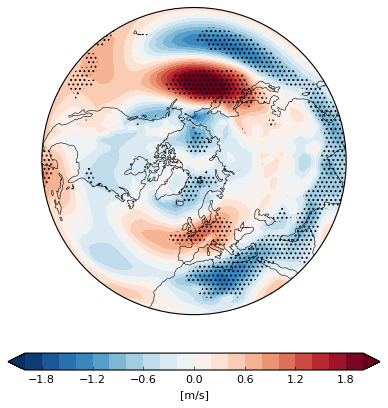

In [29]:
import matplotlib.colors as mcolors
import matplotlib        as mpl

plt.style.use('classic')
# plt.style.use('seaborn-ticks')

#create the figure default:
fig = plt.figure(figsize=(6,6),facecolor='none')
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 15,90], ccrs.PlateCarree())
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. 
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
 
color = 'RdBu_r' # The color of the filled contours, there are many options, so get creative!

colorbarMin=-2
colorbarMax=2
colorspace=0.2
clevel_p0 = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

colorbarMin=5
colorbarMax=100
colorspace=5
clevel2 = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

# set hatching for each level
hatches =  ['...', None]
p_levels = [0,0.9]
# p_levels = [0.0, 0.1]

flag_ensm_anom, cyclic_lons = add_cyclic_point((diffU_djf_em_models_mmm[:,:]), coord=longitude)
flag_ensm_clim, cyclic_lons = add_cyclic_point(Upast_djf_mmm, coord=longitude)
flag_ensm_stat, cyclic_lons = add_cyclic_point(p_by_models_normalized, coord=longitude)


# plot contours
h1 = ax.contourf(cyclic_lons,latitude, flag_ensm_anom, clevel_p0, cmap=color, extend='both',transform=ccrs.PlateCarree())
# h2 = ax.contour(cyclic_lons,latitude, flag_ensm_clim, clevel2, colors=['black'],transform=ccrs.PlateCarree())
hs = ax.contourf(cyclic_lons, latitude, flag_ensm_stat, levels=p_levels, hatches=hatches,
                  colors='none',extend='both',transform=ccrs.PlateCarree())


#plot the colorbar:
cbar = plt.colorbar(h1, orientation='horizontal', shrink=1,fraction=0.1,pad=0.1,aspect=20)
cbar.ax.tick_params(labelsize=10) 
colorLabel='[m/s]'
cbar.set_label(label=colorLabel,fontsize=10)


# ax.gridlines(draw_labels=True, dms=True, x_inline=True, y_inline=False)
ax.coastlines(linewidth=0.5)
ax.set_visible(True)


savelocation="Figures_cmip/"
savefileName='new_map_u_future_minus_past_ssp585_NorthPolarStereo.pdf'
fig.savefig(savelocation+savefileName)




In [31]:
# compute significance using FDR correction for multiple tests
from statsmodels.sandbox.stats import multicomp

P = np.abs(p_array_S_array) # array with all p-values from the two-sided t-test of the regression values  
    
# FDR control:
alpha_FDR = 0.10 # twice alpha=0.05 ?

tt,ll = P.shape
ad_p_array = np.zeros((tt,ll))

for ii in np.arange(0,ll,1):
        adjusted_pvalues = multicomp.multipletests(P[:,ii], method='fdr_bh',alpha=alpha_FDR)
        ad_p=adjusted_pvalues[1] 
        ad_p_array[:,ii]=ad_p
        
pfdr=ad_p_array
print(pfdr.shape)

(73, 144)


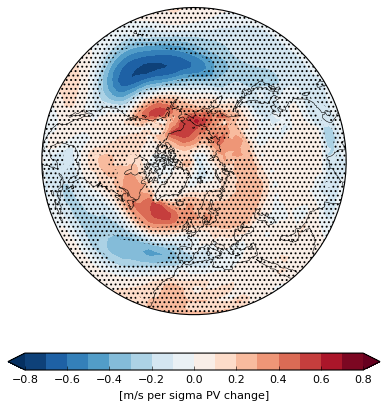

In [32]:
# regress on PV
import matplotlib.colors as mcolors
import matplotlib        as mpl

plt.style.use('classic')
# plt.style.use('seaborn-ticks')

#create the figure default:
fig = plt.figure(figsize=(6,6),facecolor='none')
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 15,90], ccrs.PlateCarree())
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. 
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
 
color = 'RdBu_r' # The color of the filled contours, there are many options, so get creative!

colorbarMin=-0.8
colorbarMax=0.8
colorspace=0.1
clevel_p0 = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

colorbarMin=5
colorbarMax=100
colorspace=5
clevel2 = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

# set hatching for each level
hatches =  ['...', None]
p_levels = [0,0.1]
# p_levels = [0.99,1.]

flag_ensm_anom, cyclic_lons = add_cyclic_point((S_array[:,:]), coord=longitude)
flag_ensm_clim, cyclic_lons = add_cyclic_point(Upast_djf_mmm, coord=longitude)
flag_ensm_stat, cyclic_lons = add_cyclic_point(pfdr, coord=longitude)


h1 = ax.contourf(cyclic_lons,latitude, flag_ensm_anom, clevel_p0, cmap=color, extend='both',transform=ccrs.PlateCarree())
# h2 = ax.contour(cyclic_lons,latitude, flag_ensm_clim, clevel2, colors=['black'],transform=ccrs.PlateCarree())
hs = ax.contourf(cyclic_lons, latitude, flag_ensm_stat, levels=p_levels, hatches=hatches,
                  colors='none',extend='both',transform=ccrs.PlateCarree())



#plot the colorbar:
cbar = plt.colorbar(h1, orientation='horizontal', shrink=1,fraction=0.1,pad=0.1,aspect=20)
cbar.ax.tick_params(labelsize=10) 
colorLabel='[m/s per sigma PV change]'
cbar.set_label(label=colorLabel,fontsize=10)


# ax.gridlines(draw_labels=True, dms=True, x_inline=True, y_inline=False)
ax.coastlines(linewidth=0.5)
ax.set_visible(True)


savelocation="Figures_cmip/"
savefileName='new_map_u_future_minus_past_ssp585_regressed_on_PV_NorthPolarStereo.pdf'
fig.savefig(savelocation+savefileName)







